In [2]:
import pandas as pd

from tms_risk.utils import get_subjects, get_tms_conditions, get_all_behavior
from tqdm.contrib.itertools import product
import seaborn as sns
import pingouin
import numpy as np
import matplotlib.pyplot as plt
import os.path as op

bids_folder  = '/data/ds-tmsrisk'

stimulation_palette = sns.color_palette()[2:4]
stimulation_order = ['Vertex', 'IPS']

# Only TMS cluster

In [3]:
subjects = get_subjects(all_tms_conditions=True)

/Users/gdehol/mambaforge/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [19]:
pars = []
keys = []

for sub, session, roi in product(subjects, [2,3], ['NPCr2cm-cluster']):

    try:
        pars.append(sub.get_prf_parameters_volume(session, smoothed=True, retroicor=False, denoise=True, cross_validated=False, natural_space=True, roi=roi,
                                                  new_parameterisation=True))
        keys.append((sub.subject, session, roi))
    except Exception as e:
        print(e)

pars = pd.concat(pars, keys=keys, names=['subject', 'session', 'roi'])
tms_conditions = get_tms_conditions()
for key in tms_conditions:
    tms_conditions[key][1] = 'baseline'

pars['stimulation_condition'] = pars.reset_index().apply(lambda d: tms_conditions[d['subject']][d['session']],  axis=1).values
pars = pars.set_index('stimulation_condition', append=True)
pars.index = pars.index.set_names('voxel', level=-2)


  0%|          | 0/70 [00:00<?, ?it/s]

In [5]:
pars_ = pars.copy()

* Find distribution of mus
* Find amplitudes as function of mus
* Find R2 as a function of mus

# Use only pars with CVr > 0.0 _within session_ and then see effect of brain sitmulation

In [6]:
cvr2 = pars.droplevel('session')['cvr2'].unstack('stimulation_condition')
mask = (cvr2 > 0.0).any(axis=1)

In [7]:
# thr_pars = pars[pars.cvr2 > -0.01]
thr_pars = pars.droplevel('session').loc[mask]

tmp = thr_pars.groupby(['subject', 'stimulation_condition']).mean().stack().to_frame('value')

In [8]:
from IPython.display import display

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,stimulation_condition,ips,vertex,True,True,-3.041923,34.0,two-sided,0.004507,8.472,-0.630501


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,stimulation_condition,ips,vertex,True,True,-0.740025,34.0,two-sided,0.464365,0.234,-0.168494


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,stimulation_condition,ips,vertex,True,True,-2.072706,34.0,two-sided,0.045849,1.208,-0.565936


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,stimulation_condition,ips,vertex,True,True,1.586308,34.0,two-sided,0.121927,0.565,0.280483


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,stimulation_condition,ips,vertex,True,True,-2.198662,34.0,two-sided,0.034806,1.51,-0.470823


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,stimulation_condition,ips,vertex,True,True,0.88466,34.0,two-sided,0.382553,0.26,0.162439


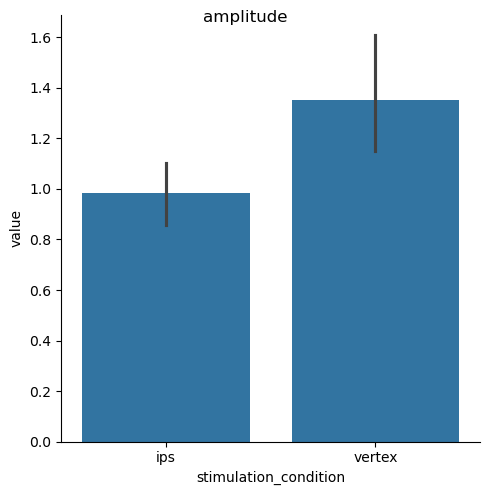

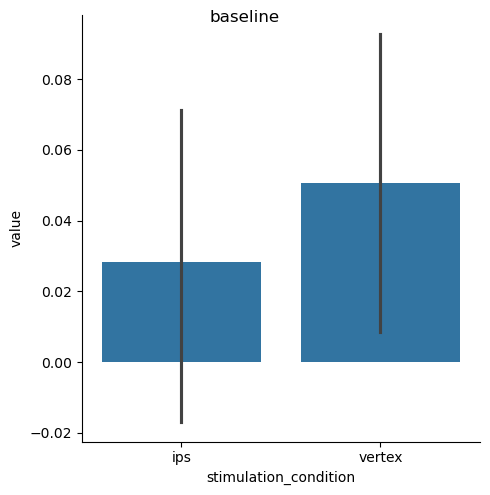

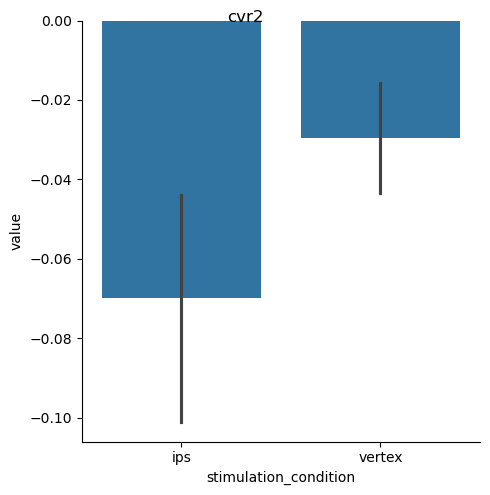

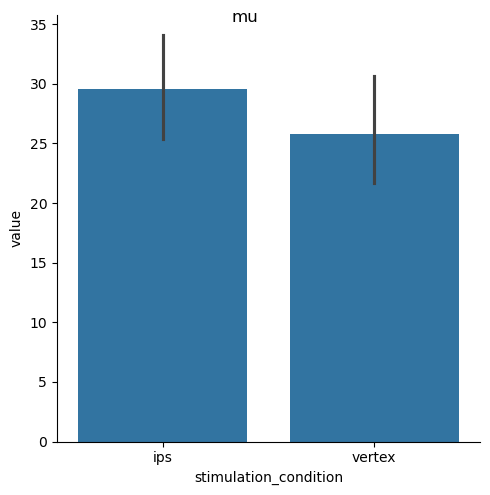

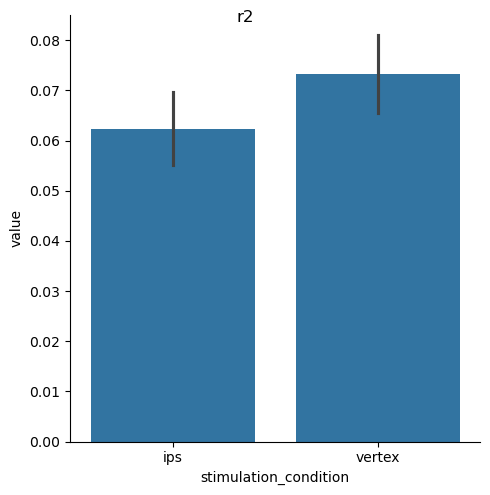

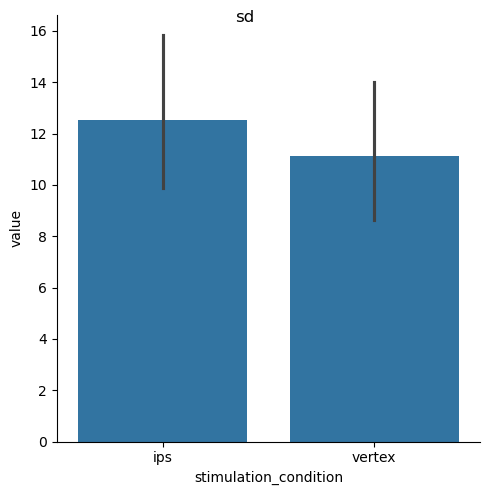

In [9]:
for par, tmp2 in tmp.groupby('parameter'):
    #  tmp.drop('baseline', level='stimulation_condition').xs('amplitude', 0, 'parameter').groupby(['subject', 'stimulation_condition']).mean().reset_index()

    ax = sns.catplot(x='stimulation_condition', y='value', data=tmp2.reset_index(), kind='bar')
    plt.gcf().suptitle(par)
    # print(pingouin.rm_anova(tmp2.reset_index(), 'value', 'stimulation_condition', 'subject'))
    display(pingouin.pairwise_tests(data=tmp2.reset_index(), dv='value', within='stimulation_condition', subject='subject'))


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,stimulation_condition,1,34,3.019308,0.09133,0.028887,1.0


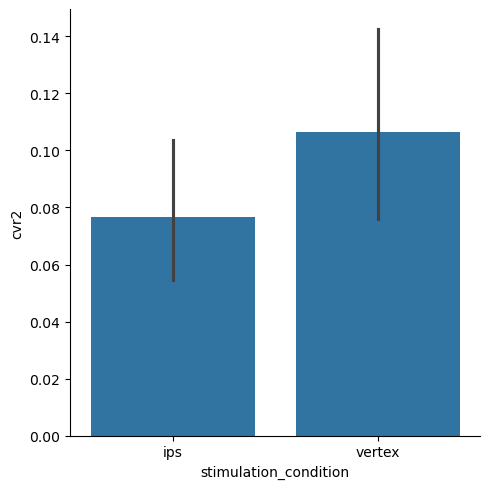

In [10]:
tmp = (pars['cvr2'] > 0.0).groupby(['subject', 'stimulation_condition']).mean().reset_index()

sns.catplot(x='stimulation_condition', y='cvr2', data=tmp.reset_index(), kind='bar')

pingouin.rm_anova(tmp, 'cvr2', 'stimulation_condition', 'subject')

In [18]:
thr_pars.to_csv(op.join(bids_folder, 'derivatives', 'encoding_models', 'prf_parameters_thr.tsv'), sep='\t')

In [11]:

# thr_pars_ = thr_pars[thr_pars['mu'] <]
thr_pars = thr_pars[thr_pars['cvr2'] > 0.0]
thr_pars['mu_bin'] = pd.cut(thr_pars['log_mu'], bins=10)

# Convert to midpoint
thr_pars['mu_bin'] = thr_pars['mu_bin'].apply(lambda x: x.mid)

tmp = thr_pars.groupby(['subject', 'stimulation_condition', 'mu_bin']).median().reset_index()
tmp['stimulation_condition'] = tmp['stimulation_condition'].map({'vertex':'Vertex', 'ips':'IPS'})

sns.relplot(x='mu_bin', y='amplitude', hue='stimulation_condition', data=tmp.reset_index(), kind='line', errorbar='se', palette=stimulation_palette, hue_order=stimulation_order, height=6., aspect=1., legend=False)

# Make logarithimic xticks for unique mu_bins values
xticks = np.unique(tmp['mu_bin'])
# xticks = np.array([x.mid for x in xticks])
plt.gca().set_xticks(xticks)
plt.gca().set_xticklabels(np.round(np.exp(xticks)))

tmp = thr_pars.groupby(['mu_bin', 'subject', 'stimulation_condition']).median()

pingouin.rm_anova(tmp.reset_index(), 'amplitude', ['stimulation_condition', 'mu_bin'], 'subject')


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3791, in get_loc
    return self._engine.get_loc(casted_key)
  File "index.pyx", line 152, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 181, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7080, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'log_mu'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_259/2255147919.py", line 3, in <module>
    thr_pars['mu_bin'] = pd.c

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:279: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', 

<Axes: xlabel='mu', ylabel='Density'>

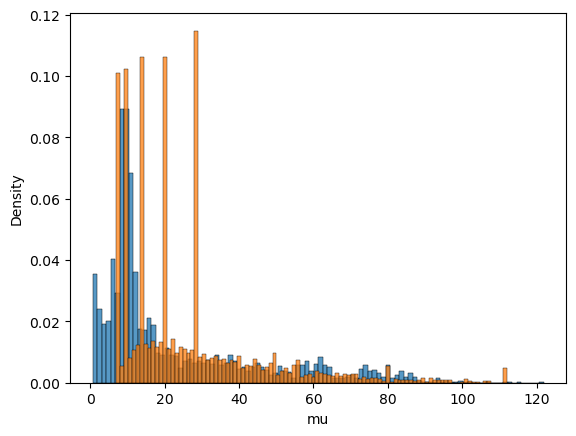

In [ ]:
from tms_risk.utils.data import get_all_behavior
sns.set_contect('font')

df = get_all_behavior()
sns.histplot(thr_pars['mu'], bins=100, kde=False, stat='density')
sns.histplot(df['n1'], bins=100, kde=False, stat='density')
sns.despine()

In [93]:
df

onset  phase  response  nr_frames     n  \
subject session run trial_nr                                                 
01      1       1   1          68.826307      5       NaN       30.0  11.0   
                    2          76.016292      5      19.0       31.0  23.0   
                    3          87.026471      5      25.0       30.0  23.0   
                    4          97.085656      5      24.0       30.0  22.0   
                    5         106.744768      5      17.0       31.0  21.0   
...                                  ...    ...       ...        ...   ...   
41      2       8   26        275.797056      5      25.0       30.0  24.0   
                    27        286.857371      5      24.0       30.0  19.0   
                    28        296.683059      5      22.0       30.0  17.0   
                    29        307.476458      5      19.0       30.0  19.0   
                    30        317.202043      5      19.0       30.0  19.0   

                              jitter  start_marker_position  response_time  \
subject session run trial_nr                                                 
01      1       1   1            6.0                   24.0            NaN   
                    2            4.0                   14.0       1.317963   
                    3            6.0                   11.0       0.834244   
                    4            5.0                   22.0       1.701381   
                    5            5.0                   22.0       2.018881   
...                              ...                    ...            ...   
41      2       8   26           4.0                   12.0       1.635028   
                    27           6.0                   15.0       1.701679   
                    28           5.0                   15.0       0.100000   
                    29           6.0                   20.0       1.751607   
                    30           5.0                   24.0       0.049945   

                               onset_abs  duration   range  error  abs_error  \
subject session run trial_nr                                                   
01      1       1   1          76.378611  0.500457  narrow    NaN        NaN   
                    2          83.568595  0.517188  narrow   -4.0        4.0   
                    3          94.578775  0.500469  narrow    2.0        2.0   
                    4         104.637959  0.500559  narrow    2.0        2.0   
                    5         114.297072  0.517009  narrow   -4.0        4.0   
...                                  ...       ...     ...    ...        ...   
41      2       8   26        278.746204  0.500532  narrow    1.0        1.0   
                    27        289.806518  0.500510  narrow    5.0        5.0   
                    28        299.632207  0.500525  narrow    5.0        5.0   
                    29        310.425606  0.500458  narrow    0.0        0.0   
                    30        320.151190  0.500598  narrow    0.0        0.0   

                              squared_error  
subject session run trial_nr                 
01      1       1   1                   NaN  
                    2                  16.0  
                    3                   4.0  
                    4                   4.0  
                    5                  16.0  
...                                     ...  
41      2       8   26                  1.0  
                    27                 25.0  
                    28                 25.0  
                    29                  0.0  
                    30                  0.0  

[18720 rows x 14 columns]

# All ROIs

In [61]:
pars = []
keys = []

for sub, session, roi in product(subjects, [2,3], ['NPC1l', 'NPC1r', 'NPC2l', 'NPC2r', 'NPC3l', 'NPC3r', 'NTOl', 'NTOr', 'NF1l', 'NF1r', 'NF2l', 'NF2r', 'NPCr1cm-cluster', 'NPCr2cm-cluster']):

    try:
        pars.append(sub.get_prf_parameters_volume(session, smoothed=True, retroicor=False, denoise=True, cross_validated=False, natural_space=True, roi=roi, keys=['mu', 'sd', 'amplitude', 'cvr2']))
        keys.append((sub.subject, session, roi))
    except Exception as e:
        print(e)

pars = pd.concat(pars, keys=keys, names=['subject', 'session', 'roi'])
tms_conditions = get_tms_conditions()
for key in tms_conditions:
    tms_conditions[key][1] = 'baseline'

pars['stimulation_condition'] = pars.reset_index().apply(lambda d: tms_conditions[d['subject']][d['session']],  axis=1).values
pars = pars.set_index('stimulation_condition', append=True)
pars.index = pars.index.set_names('voxel', level=-2)


  0%|          | 0/980 [00:00<?, ?it/s]

In [62]:
cvr2 = pars.droplevel('session')['cvr2'].unstack('stimulation_condition')
mask = (cvr2 d> 0.0).any(axis=1)

In [63]:
thr_pars = pars.droplevel('session').loc[mask]

tmp = thr_pars.groupby(['subject', 'stimulation_condition', 'roi']).mean().stack().to_frame('value')

amplitude


,,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
roi,,,,,,,,,,,,
NF1l,0,stimulation_condition,ips,vertex,True,True,-1.283932,34.0,two-sided,0.207847,0.385,-0.312304
NF1r,0,stimulation_condition,ips,vertex,True,True,-1.441424,34.0,two-sided,0.158613,0.466,-0.274071
NF2l,0,stimulation_condition,ips,vertex,True,True,-0.166702,34.0,two-sided,0.868592,0.184,-0.041980
NF2r,0,stimulation_condition,ips,vertex,True,True,1.666461,34.0,two-sided,0.104810,0.633,0.347876
NPC1l,0,stimulation_condition,ips,vertex,True,True,-0.129567,34.0,two-sided,0.897673,0.183,-0.023985
NPC1r,0,stimulation_condition,ips,vertex,True,True,-1.785802,34.0,two-sided,0.083054,0.757,-0.383959
NPC2l,0,stimulation_condition,ips,vertex,True,True,-0.750527,34.0,two-sided,0.458101,0.236,-0.110642
NPC2r,0,stimulation_condition,ips,vertex,True,True,-1.820494,34.0,two-sided,0.077496,0.798,-0.356672
NPC3l,0,stimulation_condition,ips,vertex,True,True,1.378419,34.0,two-sided,0.177077,0.431,0.304792


cvr2


,,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
roi,,,,,,,,,,,,
NF1l,0,stimulation_condition,ips,vertex,True,True,-0.646889,34.0,two-sided,0.522048,0.22,-0.175740
NF1r,0,stimulation_condition,ips,vertex,True,True,-1.485008,34.0,two-sided,0.146755,0.493,-0.408594
NF2l,0,stimulation_condition,ips,vertex,True,True,1.157891,34.0,two-sided,0.254978,0.336,0.285211
NF2r,0,stimulation_condition,ips,vertex,True,True,0.667719,34.0,two-sided,0.508820,0.223,0.192098
NPC1l,0,stimulation_condition,ips,vertex,True,True,-1.751740,34.0,two-sided,0.088835,0.718,-0.410223
NPC1r,0,stimulation_condition,ips,vertex,True,True,0.509660,34.0,two-sided,0.613582,0.205,0.131813
NPC2l,0,stimulation_condition,ips,vertex,True,True,-2.778891,34.0,two-sided,0.008819,4.756,-0.782192
NPC2r,0,stimulation_condition,ips,vertex,True,True,-0.842256,34.0,two-sided,0.405530,0.252,-0.227090
NPC3l,0,stimulation_condition,ips,vertex,True,True,-1.616618,34.0,two-sided,0.115203,0.59,-0.391213


mu


,,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
roi,,,,,,,,,,,,
NF1l,0,stimulation_condition,ips,vertex,True,True,-0.254214,34.0,two-sided,0.800861,0.187,-0.036744
NF1r,0,stimulation_condition,ips,vertex,True,True,1.007067,34.0,two-sided,0.321016,0.29,0.158412
NF2l,0,stimulation_condition,ips,vertex,True,True,0.321080,34.0,two-sided,0.750115,0.19,0.056386
NF2r,0,stimulation_condition,ips,vertex,True,True,0.173670,34.0,two-sided,0.863155,0.184,0.026057
NPC1l,0,stimulation_condition,ips,vertex,True,True,1.995787,34.0,two-sided,0.054018,1.06,0.325692
NPC1r,0,stimulation_condition,ips,vertex,True,True,0.976319,34.0,two-sided,0.335802,0.282,0.180384
NPC2l,0,stimulation_condition,ips,vertex,True,True,1.730255,34.0,two-sided,0.092654,0.696,0.353584
NPC2r,0,stimulation_condition,ips,vertex,True,True,2.335400,34.0,two-sided,0.025560,1.945,0.388404
NPC3l,0,stimulation_condition,ips,vertex,True,True,0.942431,34.0,two-sided,0.352621,0.273,0.180910


sd


,,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
roi,,,,,,,,,,,,
NF1l,0,stimulation_condition,ips,vertex,True,True,0.532337,34.0,two-sided,0.597954,0.207,0.086030
NF1r,0,stimulation_condition,ips,vertex,True,True,-1.925429,34.0,two-sided,0.062573,0.944,-0.342657
NF2l,0,stimulation_condition,ips,vertex,True,True,-1.632518,34.0,two-sided,0.111799,0.603,-0.315621
NF2r,0,stimulation_condition,ips,vertex,True,True,0.053420,34.0,two-sided,0.957710,0.182,0.012708
NPC1l,0,stimulation_condition,ips,vertex,True,True,0.637803,34.0,two-sided,0.527874,0.219,0.098686
NPC1r,0,stimulation_condition,ips,vertex,True,True,0.205082,34.0,two-sided,0.838731,0.185,0.033421
NPC2l,0,stimulation_condition,ips,vertex,True,True,-0.301085,34.0,two-sided,0.765184,0.189,-0.058379
NPC2r,0,stimulation_condition,ips,vertex,True,True,0.396499,34.0,two-sided,0.694215,0.195,0.076636
NPC3l,0,stimulation_condition,ips,vertex,True,True,-0.364926,34.0,two-sided,0.717427,0.193,-0.072712


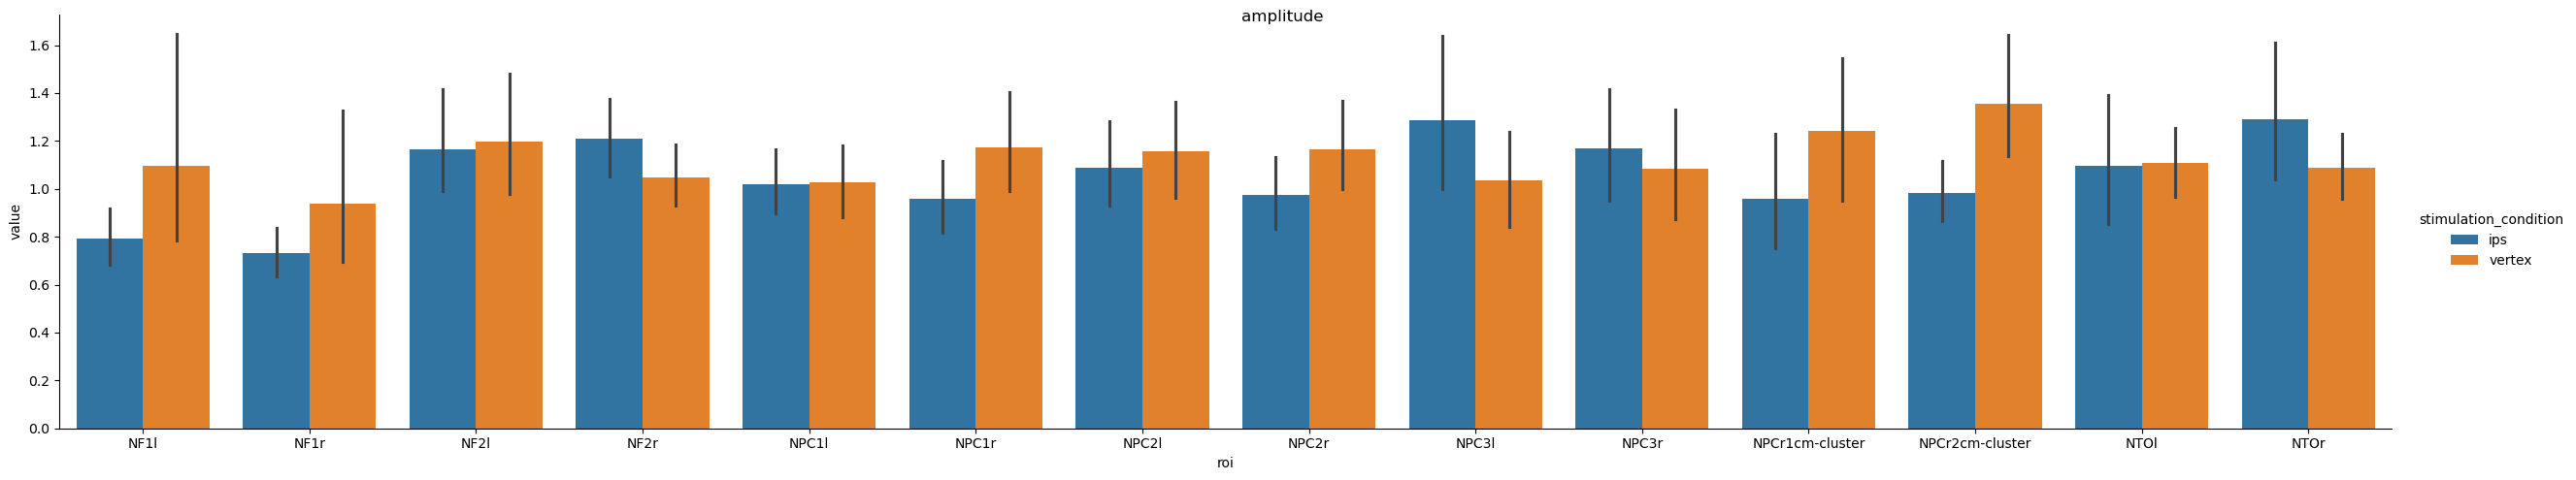

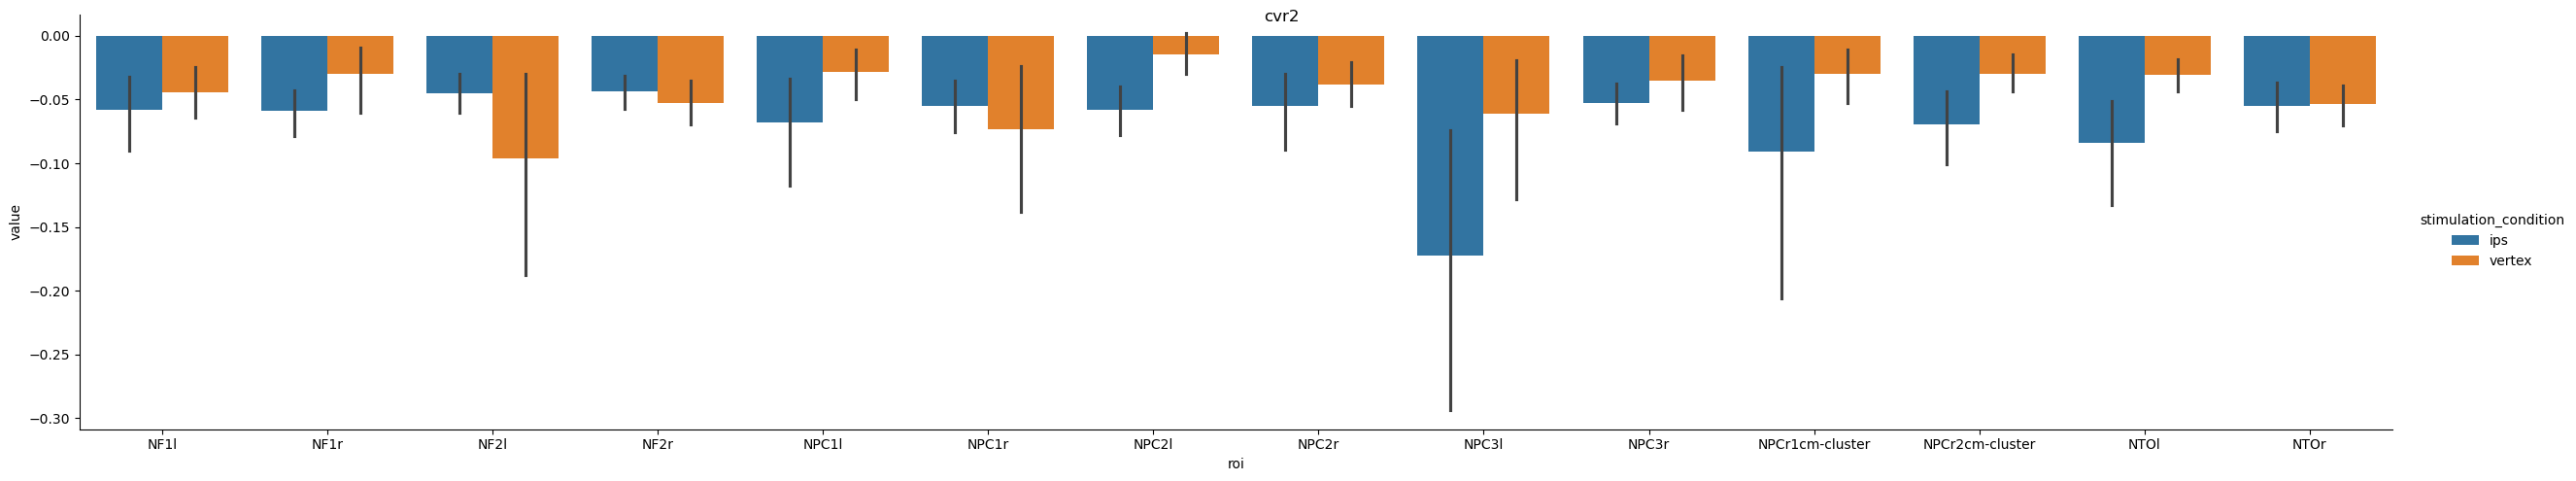

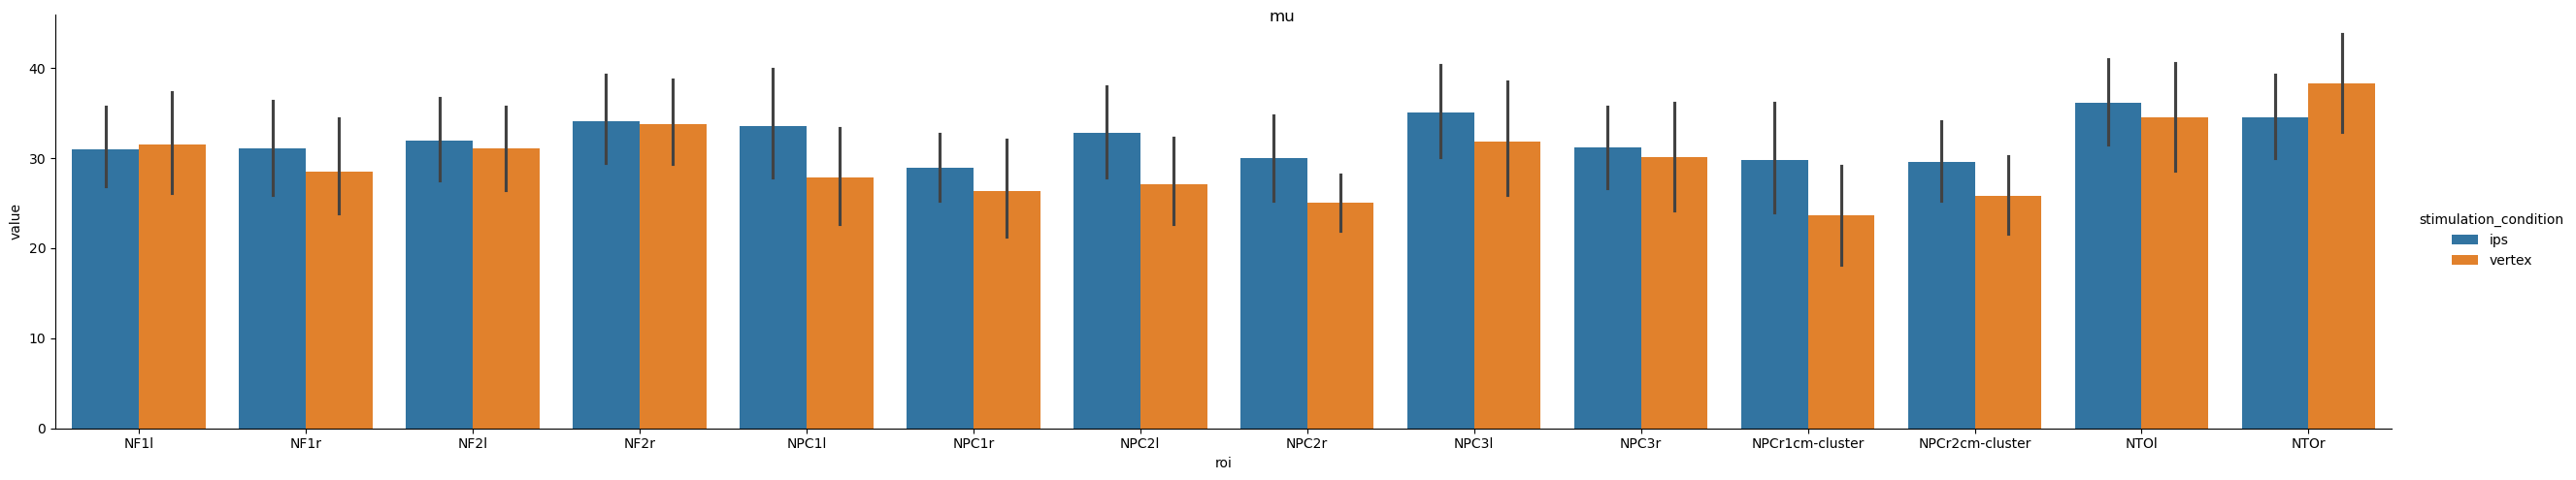

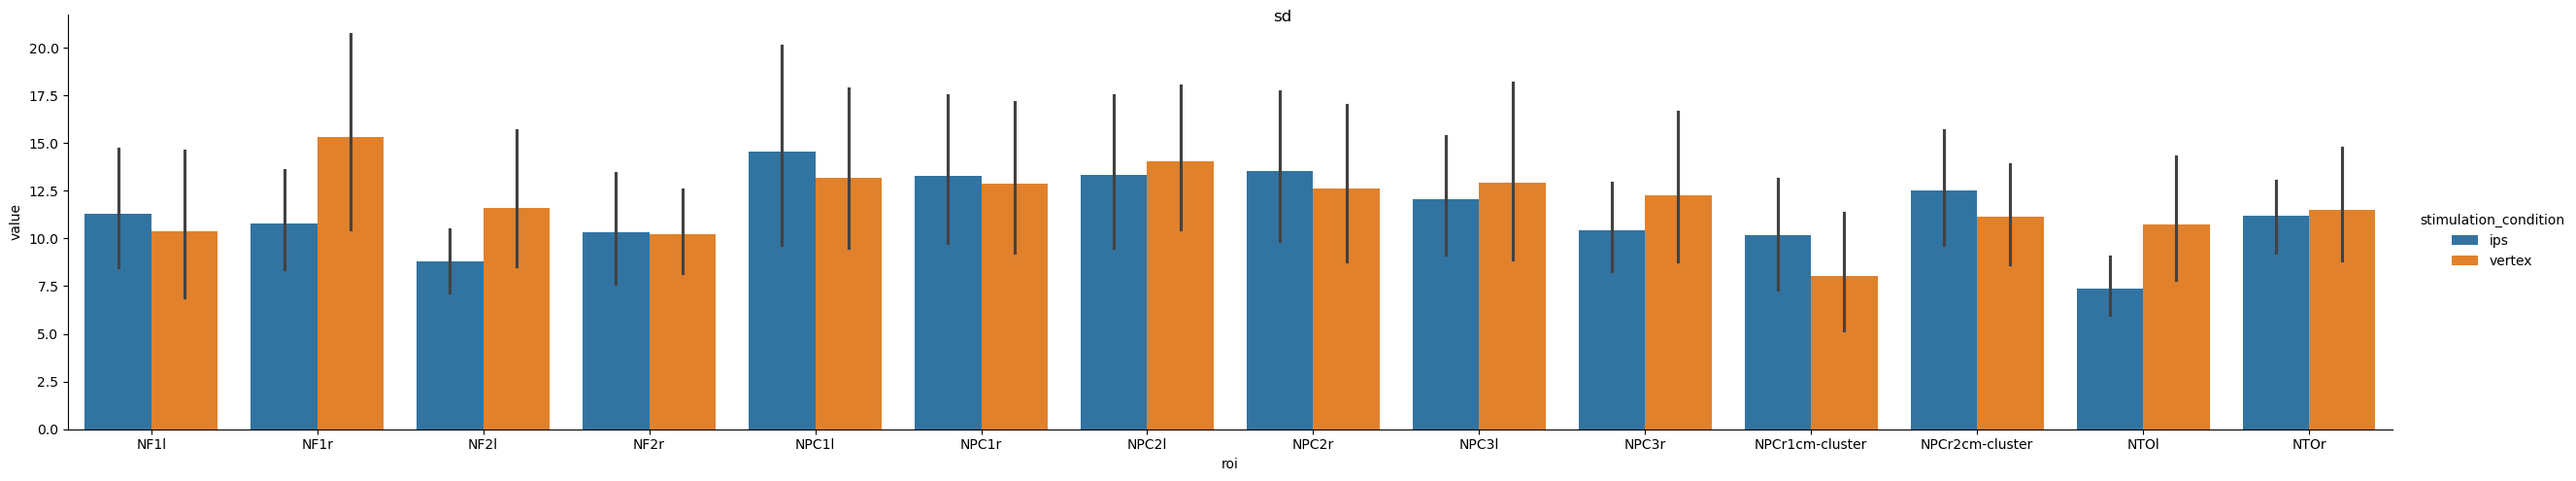

In [64]:
for par, tmp2 in tmp.groupby('parameter'):
    #  tmp.drop('baseline', level='stimulation_condition').xs('amplitude', 0, 'parameter').groupby(['subject', 'stimulation_condition']).mean().reset_index()

    ax = sns.catplot(x='roi', hue='stimulation_condition', y='value', data=tmp2.reset_index(), kind='bar', aspect=5.)
    plt.gcf().suptitle(par)
    # print(pingouin.rm_anova(tmp2.reset_index(), 'value', 'stimulation_condition', 'subject'))
    print(par)
    display(tmp2.groupby(['roi']).apply(lambda d: pingouin.pairwise_tests(d.reset_index(), dv='value', within='stimulation_condition', subject='subject')))

In [84]:
summary = thr_pars.groupby(['roi', 'subject', 'stimulation_condition']).mean().groupby(['roi', 'stimulation_condition']).agg(['mean', 'std']).unstack(-1)[['mu', 'sd', 'amplitude']].astype(np.float64).round(2)

In [92]:
summary.stack([0, 2])

mean    std
roi  parameter stimulation_condition              
NF1l amplitude ips                     0.79   0.37
               vertex                  1.10   1.31
     mu        ips                    30.95  13.58
               vertex                 31.53  17.24
     sd        ips                    11.30   9.39
...                                     ...    ...
NTOr amplitude vertex                  1.09   0.40
     mu        ips                    34.51  14.42
               vertex                 38.32  17.50
     sd        ips                    11.20   5.85
               vertex                 11.52   9.07

[84 rows x 2 columns]

In [97]:
pars.groupby(['subject', 'stimulation_con'])

parameter                                                           mu  \
subject session roi             voxel stimulation_condition              
01      2       NPC1l           0     vertex                 30.878391   
                                1     vertex                 71.111977   
                                2     vertex                 65.647110   
                                3     vertex                 31.701700   
                                4     vertex                  5.901260   
...                                                                ...   
74      3       NPCr2cm-cluster 386   vertex                 84.734146   
                                387   vertex                 91.835114   
                                388   vertex                 77.653740   
                                389   vertex                 17.343473   
                                390   vertex                 89.877274   

parameter                                                           sd  \
subject session roi             voxel stimulation_condition              
01      2       NPC1l           0     vertex                  2.744090   
                                1     vertex                  2.989669   
                                2     vertex                  1.361914   
                                3     vertex                  3.076119   
                                4     vertex                  1.294025   
...                                                                ...   
74      3       NPCr2cm-cluster 386   vertex                 11.452358   
                                387   vertex                 15.512555   
                                388   vertex                  7.393316   
                                389   vertex                  1.237352   
                                390   vertex                 10.898542   

parameter                                                    amplitude  \
subject session roi             voxel stimulation_condition              
01      2       NPC1l           0     vertex                  0.165790   
                                1     vertex                  0.417501   
                                2     vertex                  7.492101   
                                3     vertex                  0.247708   
                                4     vertex                  1.644926   
...                                                                ...   
74      3       NPCr2cm-cluster 386   vertex                  0.675586   
                                387   vertex                  1.021008   
                                388   vertex                  1.128521   
                                389   vertex                  3.804820   
                                390   vertex                  1.314028   

parameter                                                        cvr2  
subject session roi             voxel stimulation_condition            
01      2       NPC1l           0     vertex                -0.045977  
                                1     vertex                -0.097945  
                                2     vertex                -0.086884  
                                3     vertex                -1.390223  
                                4     vertex                -0.142086  
...                                                               ...  
74      3       NPCr2cm-cluster 386   vertex                -0.012774  
                                387   vertex                 0.009148  
                                388   vertex                -0.012248  
                                389   vertex                -0.123654  
                                390   vertex                 0.015947  

[238134 rows x 4 columns]

In [96]:
summary.stack([0, 2]).apply(lambda row: f'{row["mean"]} ({row["std"]})', axis=1).unstack([-2, -1])

parameter                amplitude                          mu                 \
stimulation_condition          ips       vertex            ips         vertex   
roi                                                                             
NF1l                   0.79 (0.37)   1.1 (1.31)  30.95 (13.58)  31.53 (17.24)   
NF1r                   0.73 (0.31)   0.94 (1.0)  31.07 (16.05)  28.49 (16.23)   
NF2l                   1.17 (0.64)   1.2 (0.76)   31.9 (14.01)  31.09 (14.43)   
NF2r                   1.21 (0.51)  1.05 (0.41)  34.14 (14.82)  33.76 (14.03)   
NPC1l                  1.02 (0.43)  1.03 (0.46)   33.6 (18.64)  27.82 (16.35)   
NPC1r                  0.96 (0.46)  1.17 (0.63)  28.89 (11.29)  26.39 (15.81)   
NPC2l                  1.09 (0.56)  1.16 (0.62)  32.76 (16.16)  27.05 (15.78)   
NPC2r                  0.98 (0.46)  1.17 (0.59)  29.96 (14.55)   25.0 (10.35)   
NPC3l                  1.29 (0.97)  1.04 (0.61)  35.06 (15.61)  31.87 (19.07)   
NPC3r                  1.17 (0.72)  1.08 (0.68)  31.18 (13.44)   30.1 (18.76)   
NPCr1cm-cluster        0.96 (0.69)  1.24 (0.95)  29.75 (18.83)  23.68 (16.58)   
NPCr2cm-cluster         0.98 (0.4)  1.35 (0.72)    29.6 (13.5)  25.82 (13.17)   
NTOl                    1.1 (0.84)  1.11 (0.44)  36.17 (14.12)  34.51 (18.78)   
NTOr                   1.29 (0.91)   1.09 (0.4)  34.51 (14.42)   38.32 (17.5)   

parameter                         sd                 
stimulation_condition            ips         vertex  
roi                                                  
NF1l                     11.3 (9.39)  10.35 (12.09)  
NF1r                    10.79 (8.36)  15.31 (16.46)  
NF2l                     8.81 (5.39)  11.61 (11.17)  
NF2r                    10.31 (8.98)   10.21 (7.22)  
NPC1l                  14.56 (15.17)  13.19 (12.28)  
NPC1r                  13.26 (11.54)  12.84 (13.01)  
NPC2l                  13.32 (12.06)  14.02 (11.89)  
NPC2r                  13.55 (11.72)  12.62 (12.27)  
NPC3l                   12.04 (9.96)  12.94 (14.05)  
NPC3r                   10.45 (7.02)  12.26 (11.88)  
NPCr1cm-cluster         10.18 (9.25)    8.04 (9.19)  
NPCr2cm-cluster         12.53 (9.06)    11.12 (8.1)  
NTOl                     7.39 (4.84)   10.71 (9.74)  
NTOr                     11.2 (5.85)   11.52 (9.07)